In [107]:
import os
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [117]:
# input directory path
input_dir = os.getcwd()
infilename = "data.csv"
# read input data file
in_df = pd.read_csv(os.path.join(input_dir, infilename))
# drop columns that contain only nans
#in_df = in_df.dropna(how = 'all', axis = 1)
#in_df = in_df.rename(columns = {'Gender (1 = male, 2 = female)':'Gender'})

In [125]:
class Preprocess_Dataframe:

    """ Preprocess input dataframe"""

    def __init__(self, in_df):
        self.in_df = in_df
    
    def remove_all_nans(self, axis_type: str):
        """
        Remove rows or columns containing all NaNs.

        Parameters
        ----------
        axis_type:  str
            'rows' or 'columns'
        """
        if axis_type == 'rows':
            self.in_df = self.in_df.dropna(how = 'all')
        else:
            self.in_df = self.in_df.dropna(how = 'all', axis = 1)
    
    def add_ids(self, id_vals = None):
        """
        Add id column.

        Parameters
        ----------
        in_df:  pd DataFrame
            Dataframe to operate on
        
        """
        if not id_vals:
            self.in_df['id'] = np.arange(1,self.in_df.shape[0]+1)
        else:
            self.in_df['id'] = id_vals 
    
    def rename_cols(self, old_names: list, new_names: list ):
        """
        Renames specified columns to specified new names.

        Parameters
        ----------
        old_names:  list of str
            names of columns to be renamed
        new_names:  list of str
            new column names
        """
        zipped_lists = zip(old_names, new_names)
        names_dict = dict(zipped_lists)
        self.in_df = self.in_df.rename(columns = names_dict)

    def prep_col_names(self, filter_by, suffix, split_by_num = None, suffix_2 = None):
        """
        Prep column names for use of wid_to_long method

        Parameters
        ----------
        filter_by: str
            substring to filter columns by
        prefix: str
            specify desired prefix
            for wide_to_long conversion
        """
        cols_to_prep = self.in_df.filter(like = filter_by, axis = 1).columns
        if not split_by_num:
            # NB: reduces flexibility, but can always use method overriding & child class if no longer
            # appropriate.
            prepped_col_names = ['_'.join([name.split()[0],suffix]) for name in cols_to_prep]
            self.rename_cols(cols_to_prep,prepped_col_names)
        else:
            new_names = ['numdays','enjoy','difficult']
            #prepped_col_names = ['_'.join([name, suffix]) for name in cols_to_prep[:split_by_num]]
            prepped_col_names = ['_'.join([name, suffix]) for name in new_names]
            prepped_col_names.extend(['_'.join([name, suffix_2]) for name in new_names])
            self.rename_cols(cols_to_prep,prepped_col_names)


    def reshape_data(self):
        """
        reshape df from wide to long format

        """
        col_names =  list(set([name.split('_')[0] for name in self.in_df.columns[3:-1]]))
        self.in_df_long = pd.wide_to_long(self.in_df, col_names,i = "id", j = "time", sep = '_').reset_index()
    
    def prepare_df(self):
        """
        Preprocess dataframe.
        """
        for index_name in ['rows','columns']:
            self.remove_all_nans(index_name)
        self.add_ids()
        gender_col = self.in_df.filter(like = 'Gender',axis = 1).columns
        self.rename_cols([gender_col[0], 'GHQ'], [gender_col[0].split()[0],'GHQ_0'])
        self.prep_col_names('Qual','1',3,'2')
        for filter_kw, prefix in [('baseline','0'),('day 10','1'),('day 30','2')]:
            self.prep_col_names(filter_kw,prefix)
        self.reshape_data()

In [193]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

class Data_Explorer:
    """
    Class for initial data exploration.
    """
    def __init__(self, in_df_long,group_col):
        self.in_df_long = in_df_long
        self.group_col = group_col
    
    def show_univariate_distributions(self, in_var_name, plot_type):
        pass

    def show_bivariate_distributions(self, var_names):
        pass
    
    def sample_describe(self,var_names: list, group_by = None):
        """
        describe the sample at baseline

        Parameters
        ----------
        var_names: list of str
            variables to describe
        group_by:    str
            if desribing for more than one group,
            specify name of group col
        """
        if not group_by:
            self.describe_df = self.in_df_long.loc[self.in_df_long.time==0, var_names].describe()
        else:
            var_names.extend([group_by])
            self.describe_df = self.in_df_long.loc[:,var_names].groupby(group_by).describe()
        print(self.describe_df.T)
    
    def get_baseline_diffs(self, var_name):
        """
        Test for baseline differences.

        Parameters
        ----------
        var_name: str
            name of column to perform test on
        
        Returns
            statistic and p-value
        """
        _, norm_pval = stats.normaltest(self.in_df_long.loc[:,var_name])
        if norm_pval<0.05:
            non_parametric = 1
            print(f"Feature{var_name} is not normally distributed.\nUsing Mann Whitney U test.")
        else:
            non_parametric = None

        group_names = self.in_df_long[self.group_col].unique()
        samp1 = self.in_df_long.loc[(self.in_df_long[self.group_col] == group_names[0])&(self.in_df_long.time == 0),var_name]
        samp2 = self.in_df_long.loc[(self.in_df_long[self.group_col] == group_names[1])&(self.in_df_long.time == 0),var_name]

        if not non_parametric:
            stat,p_val = stats.ttest_ind(samp1, samp2, nan_policy = 'omit')
        else:
            stat,p_val = stats.mannwhitneyu(samp1, samp2)
        
        if p_val<0.05:
            print(f"\nGroups differ significantly at baseline on feature {var_name} (pval: {p_val}).")
        else:
            print(f"\nNo significant baseline differences detected on feature {var_name} (pval:{p_val}).\n")
        return stat, p_val



In [126]:
pp = Preprocess_Dataframe(in_df)
pp.prepare_df()

In [210]:
de = Data_Explorer(pp.in_df_long,'Group')
#de.sample_describe(['GHQ','SWLS','PSS'],group_by = 'Group')
features = de.in_df_long.loc[de.in_df_long.time == 0,:].dropna(how = 'all',axis =1).columns
features = [f for f in features if f not in ['Group','time','id']]
for feature in features:
    de.get_baseline_diffs(feature)

FeatureAge is not normally distributed.
Using Mann Whitney U test.


No significant baseline differences detected on feature Age (pval:0.09284320950453397.

FeatureGender is not normally distributed.
Using Mann Whitney U test.


Groups differ significantly at baseline on feature Gender (pval: 0.035867498278359895).


No significant baseline differences detected on feature RWS (pval:0.861675981479439.


No significant baseline differences detected on feature GHQ (pval:0.7889123699778458.


No significant baseline differences detected on feature SWLS (pval:0.7445787018536658.


No significant baseline differences detected on feature PSS (pval:0.38697167128389753.



array([[<AxesSubplot:title={'center':'GHQ'}>,
        <AxesSubplot:title={'center':'SWLS'}>]], dtype=object)

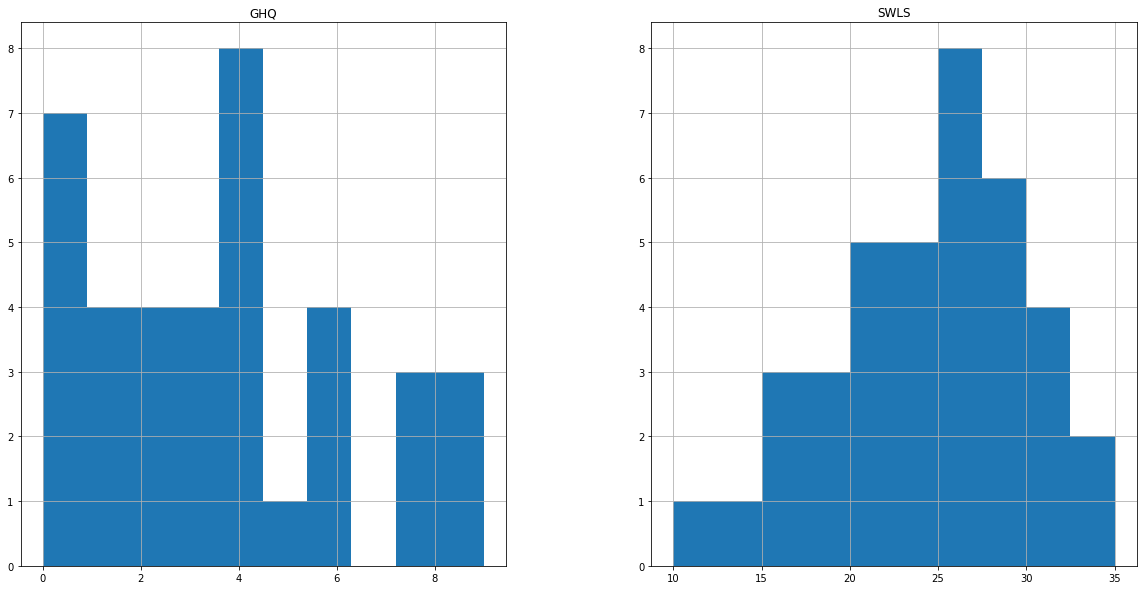

In [183]:
de.in_df_long[(de.in_df_long.time==0)&(de.in_df_long.Group=='A')].dropna(how = 'all',axis = 1).hist(column = ['GHQ','SWLS'],figsize = [20,10])


In [ ]:
de = Data_Explorer(in_df)
dem_describe = de.sample_describe(['Gender','Age'])

In [218]:
class Data_Analyzer:
    def __init__(self, in_df_long,id_col):
        self.in_df_long = in_df_long
        self.id_col = id_col

    def build_lmem(self, oc_name, predictor_names, interacts = None):
        if not interacts:
            rh_side = '+'.join(predictor_names)
        else:
            rh_side = '+'.join(predictor_names)
        self.formula = ''.join([oc_name,'~',rh_side]) 
        self.model_lmem = smf.mixedlm(self.formula, self.in_df_long, groups=self.id_col,missing = 'drop').fit()
        print(f"\nModel results:\n{self.model_lmem.summary()}")

In [221]:
da = Data_Analyzer(pp.in_df_long,"id")
da.build_lmem("PSS","C(Group,Treatment('B'))"],interacts = 1)


Model results:
                 Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      RWS      
No. Observations:       198          Method:                  REML     
No. Groups:             72           Scale:                   40.2111  
Min. group size:        1            Log-Likelihood:          -708.2324
Max. group size:        3            Converged:               Yes      
Mean group size:        2.8                                            
-----------------------------------------------------------------------
                              Coef.  Std.Err.   z   P>|z| [0.025 0.975]
-----------------------------------------------------------------------
Intercept                     69.416    8.136 8.532 0.000 53.470 85.362
C(Group, Treatment('B'))[T.A]  1.310    2.325 0.564 0.573 -3.246  5.866
Age                            0.172    0.209 0.823 0.411 -0.238  0.582
id Var                        77.473    3.061                    